In [2]:
# # IMPORTS
# astronomy
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
# plotting 
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import matplotlib as mpl
# data 
import numpy as np
import copy 
# file IO
import csv
# my python files 
import match
import v2_AGN_DataAndPlotting as adp
import v2_SED as SED

# Read Data

In [3]:
def PrintNumber(myDict) :
    for key,val in myDict.items():
        if(isinstance(val,np.ndarray)):
            print(key,'\t',len(val)) 
        elif(isinstance(val,dict)):
            print(key,end='')
            for key1,val1 in val.items():
                print('\t',key1,'\t',len(val1))

In [4]:
# read AGN IDs
agnIDs = adp.ReadFile(adp.path_csv+'\\v2_AGNid_tricolor.csv')

# convert agnIDs into dict of integer numpy arrays 
agnIDs_dict = {
    'RED' : np.array(agnIDs[0], dtype=int),
    'GRN' : np.array(agnIDs[1], dtype=int),
    'BLU' : np.array(agnIDs[2], dtype=int)
}

# verify nmber of sources
PrintNumber(agnIDs_dict)

Cropped:  ['Row 1 = MIR exclusive AGN with id, redshift, IRAC, and 24um (n=332). Row 2 = MIR-X-ray inclusive AGN with id, redshift, IRAC, and 24um (n=548). Row 3 = X-ray exclusive AGN with id, redshift, IRAC, and 24um (n=1227). ']
RED 	 332
GRN 	 548
BLU 	 1227


In [5]:
# get redshifts
zDict = adp.ReadRedshifts(file=adp.path_cat+'\COSMOS_z_matches.csv')

Cropped:  ['ID', 'z']
Number of redshifts: 485793


In [6]:
agnInfo = {}
for key,val in agnIDs_dict.items():
    # match redshift to AGN
    key_zid, key_idz = match.match(zDict['ID'], val)
    agnInfo[key] = {
        'ID' : val[key_idz],
        'z'  : zDict['z'][key_zid]
    }
# verify number of sources
PrintNumber(agnInfo)

RED	 ID 	 332
	 z 	 332
GRN	 ID 	 548
	 z 	 548
BLU	 ID 	 1227
	 z 	 1227


In [7]:
# open COSMOS 2020 catalog file and get data 
with fits.open(adp.path_cat+'\\COSMOS2020_CLASSIC_R1_v2.0_master.fits') as hdul20:
    data20 = hdul20[1].data

# Prepare SEDs

In [8]:
# get starting info 
Fnu_uJy = SED.GetPhotometry(data20, print=False)
IDs_all = SED.GetID(data20, print=False)
lam_A   = SED.GetObservedWavelengths_A(print=False)

In [9]:
for key,val in agnInfo.items():
    # match photometry to AGN
    key_agn, key_phot = match.match(val['ID'], IDs_all)
    # get phot
    Fnu = Fnu_uJy[key_phot]
    # get rest wavelength 
    lamR = SED.ConvertToRestWavelength(val['z'], print=False)
    # get energy density and normalize
    lamFlam = SED.ConvertToEnergyDensity(lamR, Fnu, print=False)
    lamFlam_norm = SED.NormalizeSED_1um(lamR, lamFlam, print=False)
    # get luminosity at 1um
    lum1um = SED.Lum_at1um(lamFlam, lamR, val['z'], )
    # append info
    val['Rest Wavelength'] = lamR
    val['Energy Density'] = lamFlam
    val['Energy Density Normalized at 1um'] = lamFlam_norm
    val['Luminosity at 1um'] = lum1um

# verify number of sources
PrintNumber(agnInfo)

RED	 ID 	 332
	 z 	 332
	 Rest Wavelength 	 332
	 Energy Density 	 332
	 Energy Density Normalized at 1um 	 332
	 Luminosity at 1um 	 332
GRN	 ID 	 548
	 z 	 548
	 Rest Wavelength 	 548
	 Energy Density 	 548
	 Energy Density Normalized at 1um 	 548
	 Luminosity at 1um 	 548
BLU	 ID 	 1227
	 z 	 1227
	 Rest Wavelength 	 1227
	 Energy Density 	 1227
	 Energy Density Normalized at 1um 	 1227
	 Luminosity at 1um 	 1227


In [10]:
# get z subsample

# initialize 
agnInfo_zle = {}
# itereate through each agn type 
for key_color, val_dict in agnInfo.items():
    # get boolean mask of redshifts <=1 
    zmask = (val_dict['z'] <= 1)
    # apply mask to each dict
    info = {}
    for key,val in val_dict.items():
        info[key] = val[zmask]
    # add info dict to larger dict 
    agnInfo_zle[key_color] = info 

# verify number of sources
PrintNumber(agnInfo_zle)

RED	 ID 	 59
	 z 	 59
	 Rest Wavelength 	 59
	 Energy Density 	 59
	 Energy Density Normalized at 1um 	 59
	 Luminosity at 1um 	 59
GRN	 ID 	 80
	 z 	 80
	 Rest Wavelength 	 80
	 Energy Density 	 80
	 Energy Density Normalized at 1um 	 80
	 Luminosity at 1um 	 80
BLU	 ID 	 301
	 z 	 301
	 Rest Wavelength 	 301
	 Energy Density 	 301
	 Energy Density Normalized at 1um 	 301
	 Luminosity at 1um 	 301


# Plot SEDs

In [11]:
def PlotSED_Row(
        x,                  # x-axis data LIST:   lam [A]
        y,                  # y-axis data LIST:  lamFlam [erg/s/cm2]
        z,                  # colorbar data LIST
        cmapKey,            # colormap options: red, grn, blu, (jet otherwise)
        n_ticks=9,          # number of ticks on colorbar
        showBar=True,       # show the colorbar 
        save='',            # filename to save
        median=True,        # plots a median line when true
        xmin=10**-2,        # plot range 
        xmax=10**3,         #   "    "
        ymin=10**-2.5,      #   "    "
        ymax=10**2.5,       #   "    "
        orientWide=False,   # true for tall, false for wide 
        cbarLabel='$Normalized \; \lambda F_{\lambda} \; at \; 24 \mu m$',
        cbarRange=None,      # tuple range of colorbar (min, max)
        title=None
):
    # check that lists are all same length 
    n = len(x)
    if(n!=len(y) and n!=len(z) and n!=len(cmapKey) ):
        print('[!] Bad inputs')
        return

    # determine subplot shape and parameters
    if(orientWide) :
        nrow = 1
        ncol = len(x)
        figsize = (4+(2*n), 4)
        cbarLocation = 'top'
    else:
        nrow = len(x)
        ncol = 1
        figsize = (6, 2+(2*n))
        cbarLocation = 'right'

    # build figure
    adp.SetStyle() 
    fig = plt.figure(figsize=figsize)    
    ax = []
    for i in range(n):
        ax.append(fig.add_subplot(nrow,ncol,i+1))
   
    # plot each SED
    for i in range(n): 
        # initialize plot settings 
        xTicks=True
        yTicks=True
        xLabel=False
        yLabel=False
        cbarLab=None
        # for wide plot 
        if(orientWide==1) : 
            if(i>0) :           
                yTicks = False
            if(i==int(n/2)):    
                xLabel = True 
                cbarLab = cbarLabel
            if(i==0) :          
                yLabel = True 
        # for tall plot 
        elif(orientWide==0) :
            if(i<n-1):          
                xTicks = False
            if(i==n-1):         
                xLabel = True 
            if(i==int(n/2)):    
                yLabel = True 
                cbarLab = cbarLabel

        # fix type
        if(isinstance(z[i], np.float64)) :
            zi = np.array([z[i]])
        else : 
            zi = z[i]
        # determine color range
        if(cbarRange):
            cbarMin=cbarRange[0]
            cbarMax=cbarRange[1]
            z_forMap = SED.PrepareCmapValues(zi,min=10**cbarMin,max=10**cbarMax)
        else : 
            z_forMap = SED.PrepareCmapValues(zi) 
            cbarMin=min(z_forMap[0])
            cbarMax=max(z_forMap[0])

        # get colormap 
        cmap_use = SED.GetCmap(cmapKey[i], n_ticks)

        # plot on axis 
        SED.PlotSED_ax(
            ax=ax[i],            
            x=x[i],             
            y=y[i],             
            z=z_forMap[1],             
            cmap=cmap_use,          
            median=median,   
            xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax,
            xTicks=xTicks,
            yTicks=yTicks,
            xLabel=xLabel,
            yLabel=yLabel
        )

        # colorbar 
        if(showBar) : 
            extend='neither'
            if(cbarRange) : 
                # check bounds
                smaller = np.nanmin(zi) < 10**cbarMin
                bigger = np.nanmax(zi) > 10**cbarMax
                if(smaller and bigger) :    extend = 'both'
                elif(smaller) :             extend = 'min'
                elif(bigger) :              extend = 'max'

            SED.PlotColorbar_ax(
                ax=ax[i], 
                cmap=cmap_use, 
                min=cbarMin, 
                max=cbarMax, 
                n_ticks=n_ticks, 
                label=cbarLab, 
                location=cbarLocation,
                extend=extend
            )

    # set title of plot 
    if(title) :
        plt.title(title)

    # save plot as image 
    if(save) : 
        adp.Save(save)
    
    # finish
    plt.show()
    plt.close()

## MIR colorbar

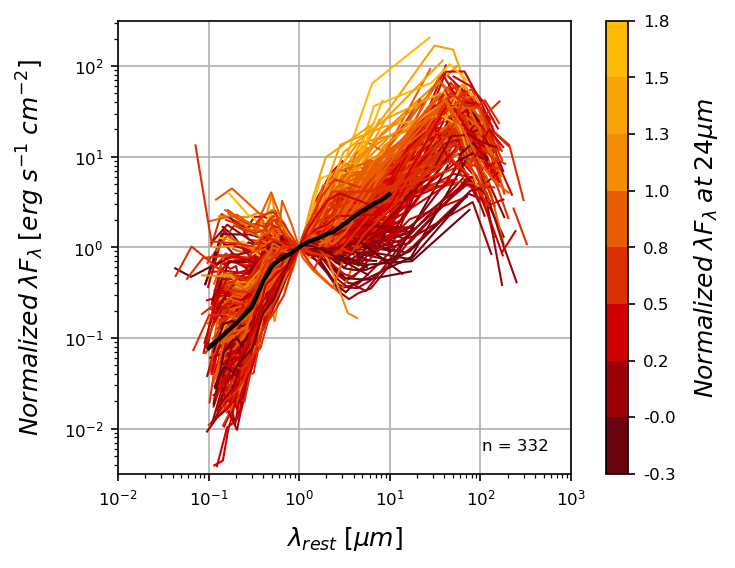

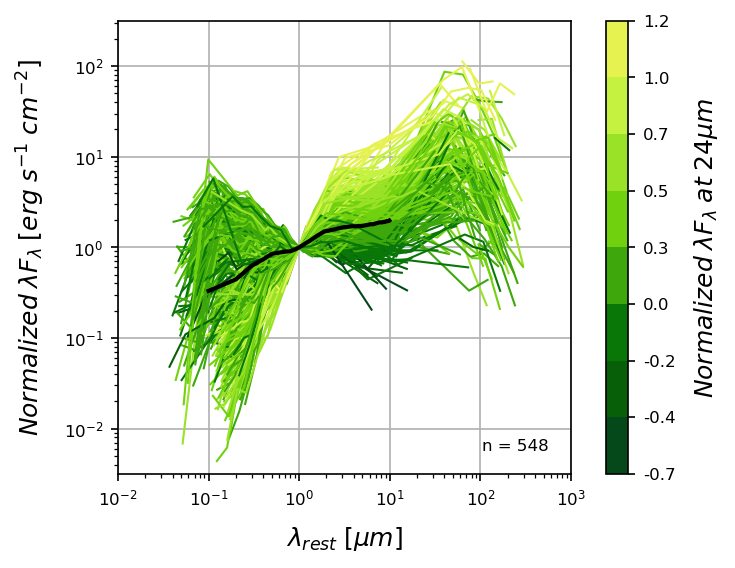

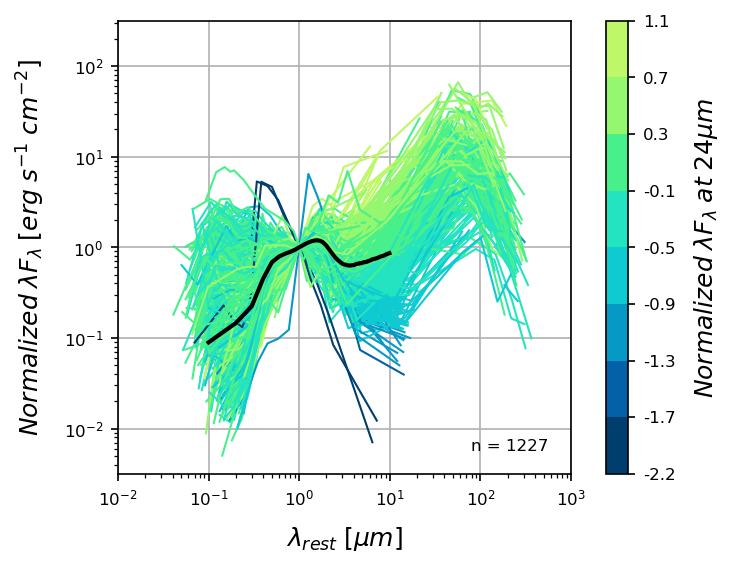

In [12]:
# plot SEDs for all color AGN 
zr = agnInfo['RED']['Energy Density Normalized at 1um'].T[14] # transpose to get 24um column
zg = agnInfo['GRN']['Energy Density Normalized at 1um'].T[14]
zb = agnInfo['BLU']['Energy Density Normalized at 1um'].T[14]
PlotSED_Row([agnInfo['RED']['Rest Wavelength']],[agnInfo['RED']['Energy Density Normalized at 1um']],[zr],cmapKey=['r'],save=adp.path_fig+'\\v2_SED_red_zAll.png')
PlotSED_Row([agnInfo['GRN']['Rest Wavelength']],[agnInfo['GRN']['Energy Density Normalized at 1um']],[zg],cmapKey=['g'],save=adp.path_fig+'\\v2_SED_yel_zAll.png')
PlotSED_Row([agnInfo['BLU']['Rest Wavelength']],[agnInfo['BLU']['Energy Density Normalized at 1um']],[zb],cmapKey=['b'],save=adp.path_fig+'\\v2_SED_blu_zAll.png')

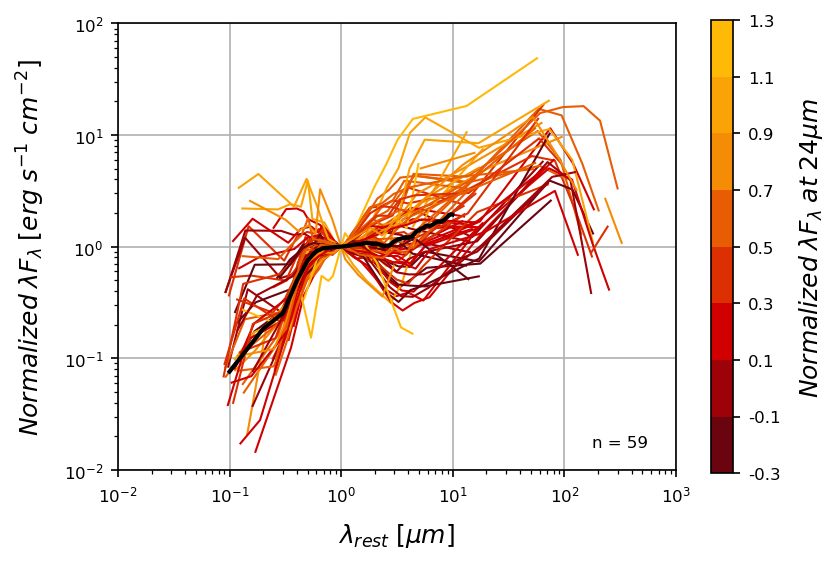

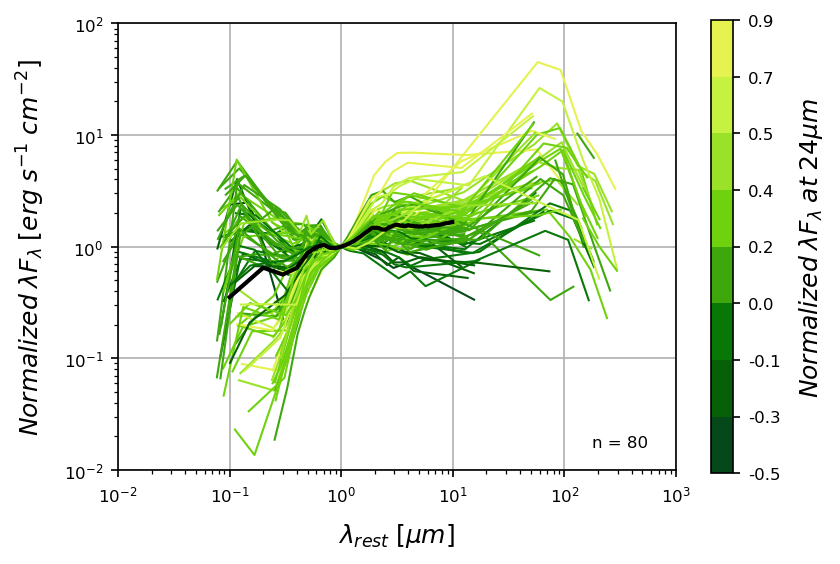

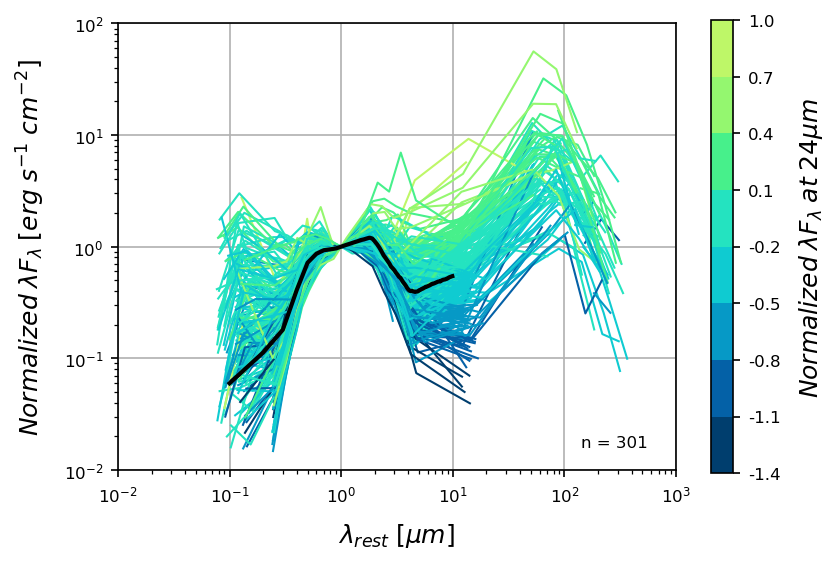

In [13]:
# plot SEDs for all color AGN 
zr = agnInfo_zle['RED']['Energy Density Normalized at 1um'].T[14] # transpose to get 24um column
zg = agnInfo_zle['GRN']['Energy Density Normalized at 1um'].T[14]
zb = agnInfo_zle['BLU']['Energy Density Normalized at 1um'].T[14]
PlotSED_Row([agnInfo_zle['RED']['Rest Wavelength']],[agnInfo_zle['RED']['Energy Density Normalized at 1um']],[zr],cmapKey=['r'],save=adp.path_fig+'\\v2_SED_red_z01.png',ymin=10**-2,ymax=10**2)
PlotSED_Row([agnInfo_zle['GRN']['Rest Wavelength']],[agnInfo_zle['GRN']['Energy Density Normalized at 1um']],[zg],cmapKey=['g'],save=adp.path_fig+'\\v2_SED_yel_z01.png',ymin=10**-2,ymax=10**2)
PlotSED_Row([agnInfo_zle['BLU']['Rest Wavelength']],[agnInfo_zle['BLU']['Energy Density Normalized at 1um']],[zb],cmapKey=['b'],save=adp.path_fig+'\\v2_SED_blu_z01.png',ymin=10**-2,ymax=10**2)

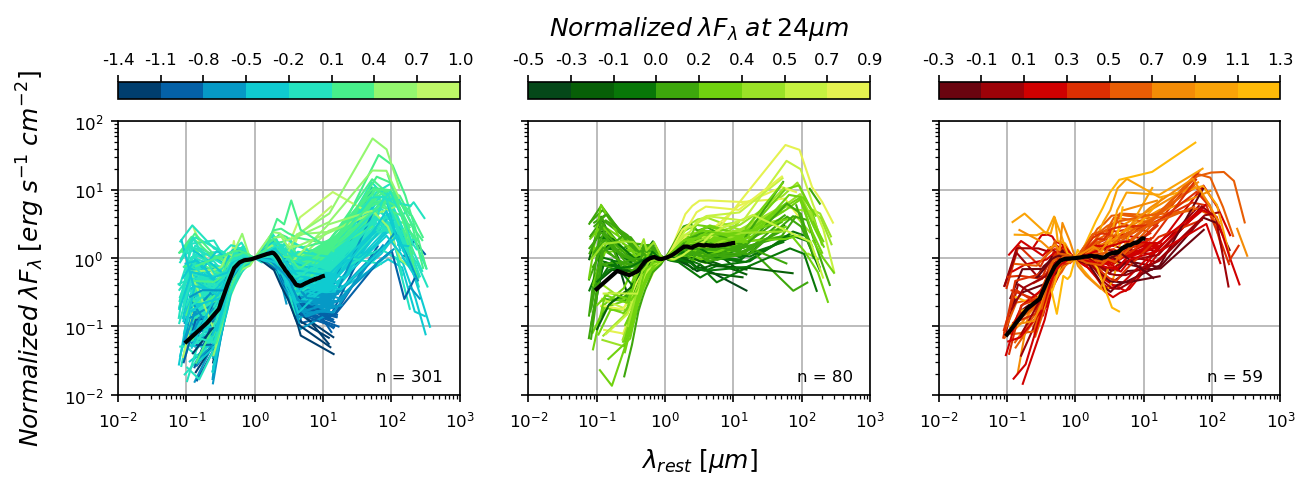

In [14]:
PlotSED_Row(
        x=[
                agnInfo_zle['BLU']['Rest Wavelength'],
                agnInfo_zle['GRN']['Rest Wavelength'],
                agnInfo_zle['RED']['Rest Wavelength']
        ],
        y=[     agnInfo_zle['BLU']['Energy Density Normalized at 1um'],
                agnInfo_zle['GRN']['Energy Density Normalized at 1um'],
                agnInfo_zle['RED']['Energy Density Normalized at 1um']
        ],            
        z=[     
                agnInfo_zle['BLU']['Energy Density Normalized at 1um'].T[14],
                agnInfo_zle['GRN']['Energy Density Normalized at 1um'].T[14],
                agnInfo_zle['RED']['Energy Density Normalized at 1um'].T[14]
        ],
        cmapKey=['b','g','r'],      
        save=adp.path_fig+'\\v2_SED_3wide_z01.png',      
        orientWide=True,
        ymin=10**-2,
        ymax=10**2
)

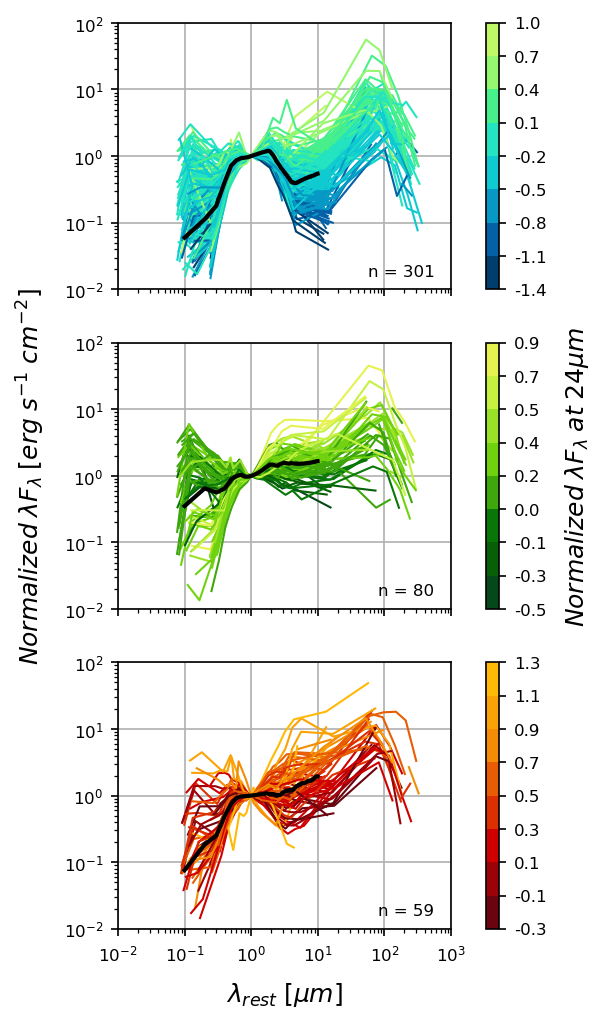

In [15]:
PlotSED_Row(
        x=[
                agnInfo_zle['BLU']['Rest Wavelength'],
                agnInfo_zle['GRN']['Rest Wavelength'],
                agnInfo_zle['RED']['Rest Wavelength']
        ],
        y=[     agnInfo_zle['BLU']['Energy Density Normalized at 1um'],
                agnInfo_zle['GRN']['Energy Density Normalized at 1um'],
                agnInfo_zle['RED']['Energy Density Normalized at 1um']
        ],            
        z=[     
                agnInfo_zle['BLU']['Energy Density Normalized at 1um'].T[14],
                agnInfo_zle['GRN']['Energy Density Normalized at 1um'].T[14],
                agnInfo_zle['RED']['Energy Density Normalized at 1um'].T[14]
        ],
        cmapKey=['b','g','r'],      
        save=adp.path_fig+'\\v2_SED_3tall_z01.png',      
        orientWide=False,
        ymin=10**-2,
        ymax=10**2
)

## L1um colorbar

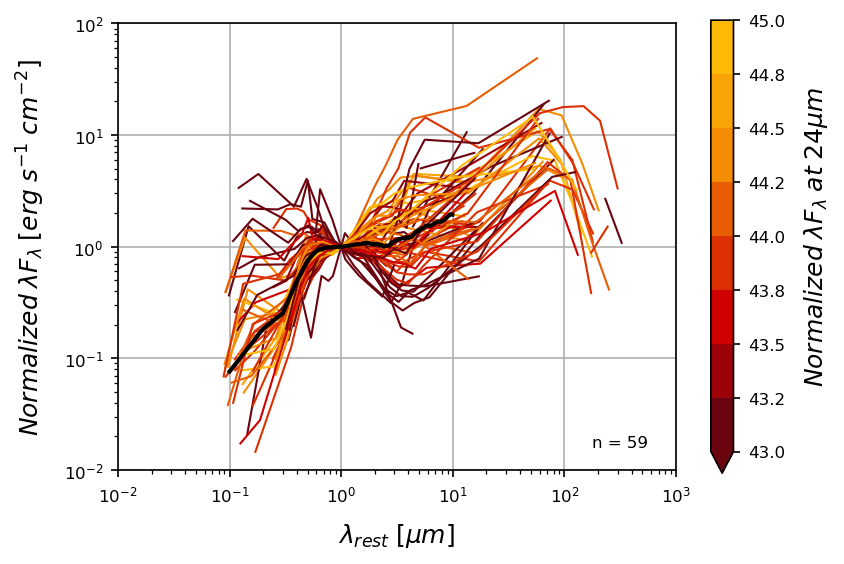

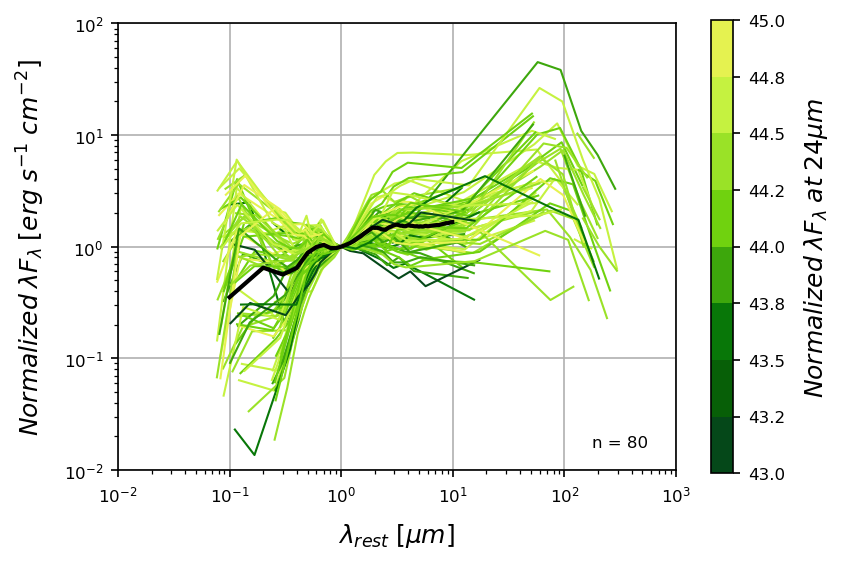

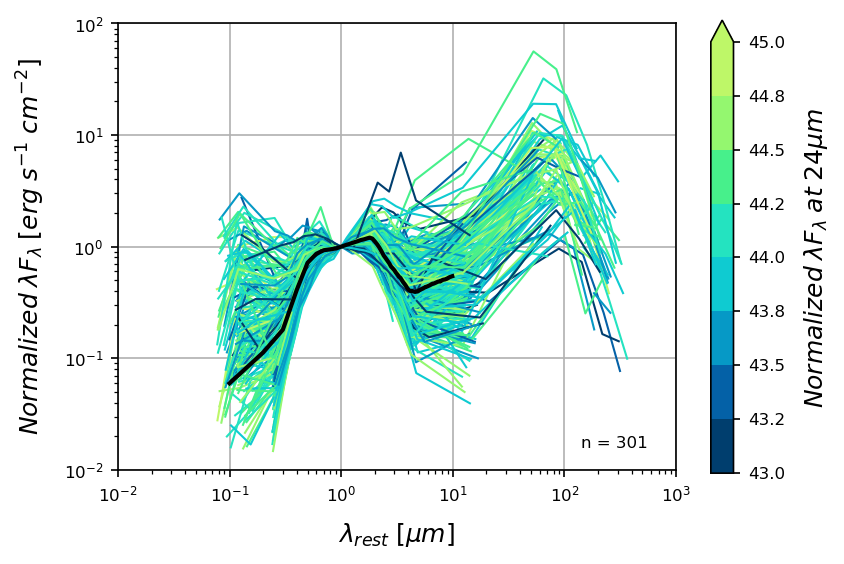

In [27]:
PlotSED_Row([agnInfo_zle['RED']['Rest Wavelength']],[agnInfo_zle['RED']['Energy Density Normalized at 1um']],[agnInfo_zle['RED']['Luminosity at 1um']],cmapKey=['r'],cbarRange=(43,45),save=adp.path_fig+'\\v2_SED_red_z01_LumCbar.png',ymin=10**-2,ymax=10**2)
PlotSED_Row([agnInfo_zle['GRN']['Rest Wavelength']],[agnInfo_zle['GRN']['Energy Density Normalized at 1um']],[agnInfo_zle['GRN']['Luminosity at 1um']],cmapKey=['g'],cbarRange=(43,45),save=adp.path_fig+'\\v2_SED_yel_z01_LumCbar.png',ymin=10**-2,ymax=10**2)
PlotSED_Row([agnInfo_zle['BLU']['Rest Wavelength']],[agnInfo_zle['BLU']['Energy Density Normalized at 1um']],[agnInfo_zle['BLU']['Luminosity at 1um']],cmapKey=['b'],cbarRange=(43,45),save=adp.path_fig+'\\v2_SED_blu_z01_LumCbar.png',ymin=10**-2,ymax=10**2)

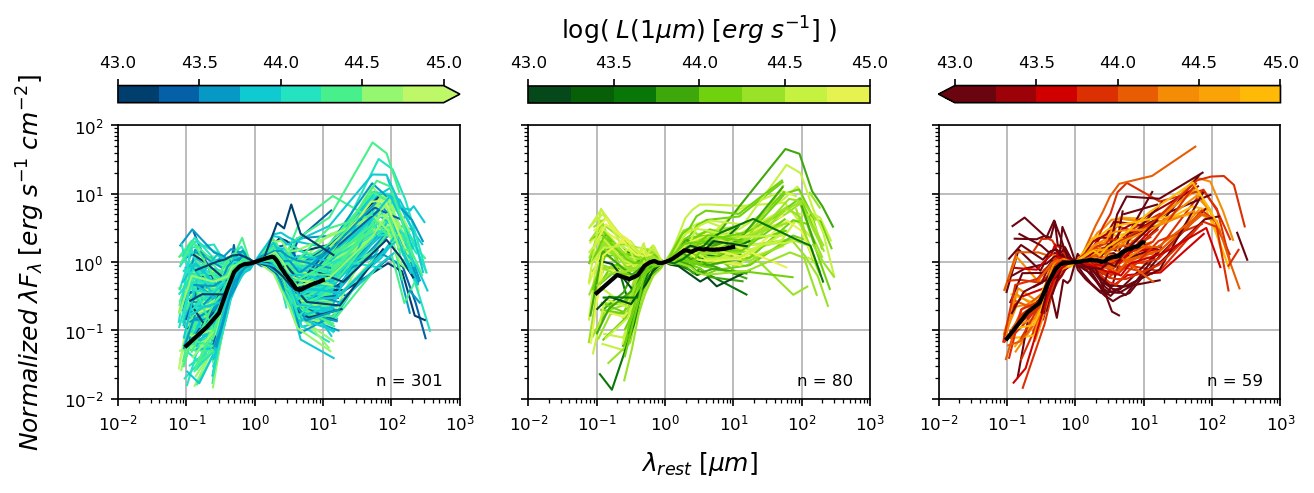

In [17]:
PlotSED_Row(
        x=[
                agnInfo_zle['BLU']['Rest Wavelength'],
                agnInfo_zle['GRN']['Rest Wavelength'],
                agnInfo_zle['RED']['Rest Wavelength']
        ],
        y=[     agnInfo_zle['BLU']['Energy Density Normalized at 1um'],
                agnInfo_zle['GRN']['Energy Density Normalized at 1um'],
                agnInfo_zle['RED']['Energy Density Normalized at 1um']
        ],            
        z=[     
                agnInfo_zle['BLU']['Luminosity at 1um'],
                agnInfo_zle['GRN']['Luminosity at 1um'],
                agnInfo_zle['RED']['Luminosity at 1um']
        ],
        cmapKey=['b','g','r'],      
        save=adp.path_fig+'\\v2_SED_3wide_z01_LumCbar.png',      
        orientWide=True,
        cbarLabel='$\log( \; L(1 \mu m) \; [erg \; s^{-1}] \;)$',
        cbarRange=(43,45),
        n_ticks=5,
        ymin=10**-2,
        ymax=10**2
)

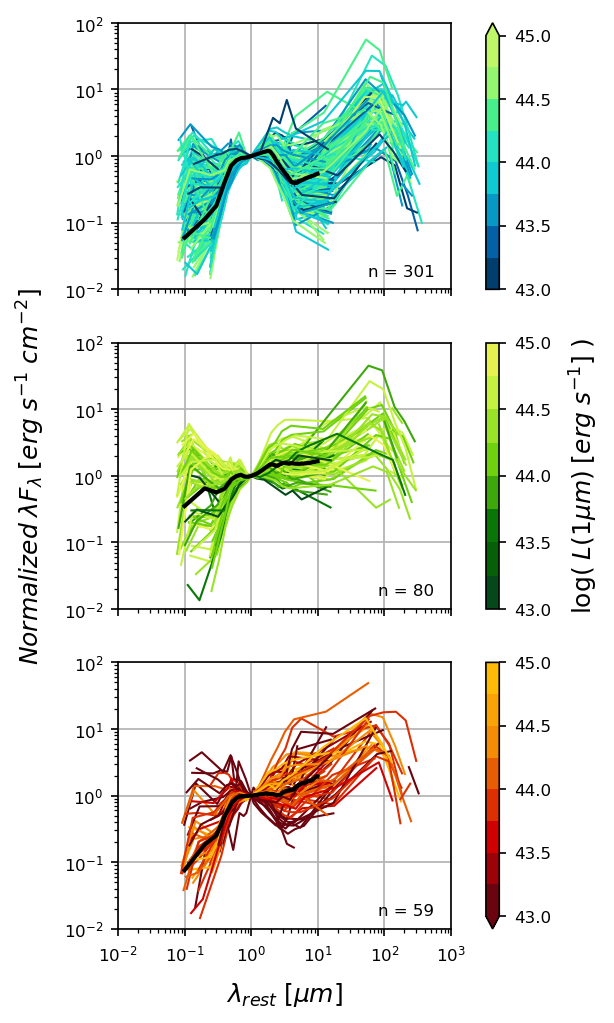

In [18]:
PlotSED_Row(
        x=[
                agnInfo_zle['BLU']['Rest Wavelength'],
                agnInfo_zle['GRN']['Rest Wavelength'],
                agnInfo_zle['RED']['Rest Wavelength']
        ],
        y=[     agnInfo_zle['BLU']['Energy Density Normalized at 1um'],
                agnInfo_zle['GRN']['Energy Density Normalized at 1um'],
                agnInfo_zle['RED']['Energy Density Normalized at 1um']
        ],            
        z=[     
                agnInfo_zle['BLU']['Luminosity at 1um'],
                agnInfo_zle['GRN']['Luminosity at 1um'],
                agnInfo_zle['RED']['Luminosity at 1um']
        ],
        cmapKey=['b','g','r'],      
        save=adp.path_fig+'\\v2_SED_3tall_z01_LumCbar.png',      
        orientWide=False,
        cbarLabel='$\log( \; L(1 \mu m) \; [erg \; s^{-1}] \;)$',
        cbarRange=(43,45),
        n_ticks=5,
        ymin=10**-2,
        ymax=10**2
)

# Luminosity histogram

In [19]:
def MeanLineForHist(x,c='k',xtext=0.998, ytext=0.94, horizAlign='right') :
    mean = np.array(x).mean()
    min_ylim, max_ylim = plt.ylim()
    plt.axvline(mean, color=c, linestyle='dashed', linewidth=2)
    plt.text(mean*xtext, max_ylim*ytext, 'Mean: {:.1f}'.format(mean), c=c, horizontalalignment=horizAlign)

In [20]:
def LogLum(lum) : 
    l = np.array(lum) # convert to array
    l = l[l>0] # exclude zeros
    l = np.log10(l) # get log of luminosity
    return(l)

In [21]:
def PlotHist_Lum1um_Triple(
    lum1_1um,c1,
    lum2_1um,c2,
    lum3_1um,c3,
    saveStr='',
    showSum=False
):
    # set style
    adp.SetStyle()

    # get log
    lum1 = LogLum(lum1_1um)
    lum2 = LogLum(lum2_1um)
    lum3 = LogLum(lum3_1um)

    if(showSum):
        lum0 = np.concatenate((lum1,lum2,lum3))
        plt.hist(lum0,bins=np.arange(38,48,0.5), histtype='bar',  color='lightgray', linewidth=2)

    # plot histogram
    plt.hist(lum3,bins=np.arange(38,48,0.5), histtype='step', edgecolor=c3,      linewidth=2)
    plt.hist(lum2,bins=np.arange(38,48,0.5), histtype='step', edgecolor=c2,      linewidth=2)
    plt.hist(lum1,bins=np.arange(38,48,0.5), histtype='step', edgecolor=c1,      linewidth=2)

    # set height to +20% max value
    min_ylim, max_ylim = plt.ylim()
    plt.ylim(ymin=0, ymax=max_ylim+0.20*max_ylim)

    # axis ticks
    plt.xticks([38,39,40,41,42,43,44,45,46,47,48])
    ax = plt.gca()
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    # mean line
    MeanLineForHist(lum1,c=c1,ytext=0.94)
    MeanLineForHist(lum2,c=c2,ytext=0.89)
    MeanLineForHist(lum3,c=c3,ytext=0.84)

    # set axis lables
    plt.xlabel('$\log( \; L(1 \mu m) \; [erg \; s^{-1}] \;)$')
    plt.ylabel('Number')
    
    # save
    if(saveStr) :
        adp.Save(saveStr)

    # finish
    plt.show()

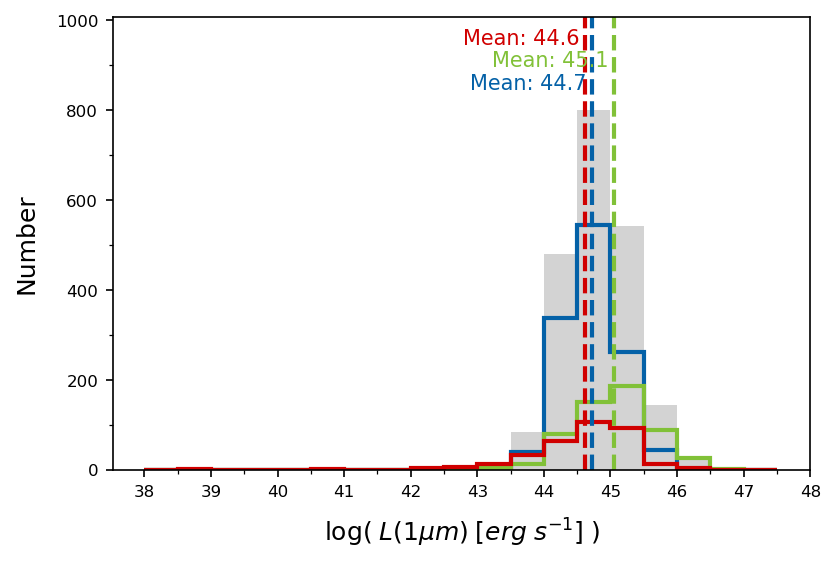

In [22]:
PlotHist_Lum1um_Triple(
    agnInfo['RED']['Luminosity at 1um'],adp.c_ir,
    agnInfo['GRN']['Luminosity at 1um'],adp.c_ir_xray,
    agnInfo['BLU']['Luminosity at 1um'],adp.c_xray,
    saveStr=adp.path_fig+'\\v2_L1umHist_zAll.png',
    showSum=True
)

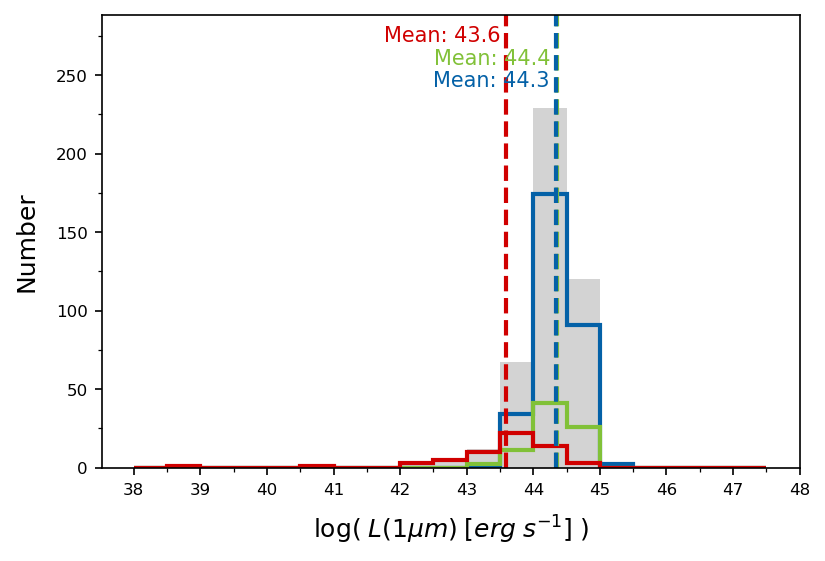

In [23]:
PlotHist_Lum1um_Triple(
    agnInfo_zle['RED']['Luminosity at 1um'],adp.c_ir,
    agnInfo_zle['GRN']['Luminosity at 1um'],adp.c_ir_xray,
    agnInfo_zle['BLU']['Luminosity at 1um'],adp.c_xray,
    saveStr=adp.path_fig+'\\v2_L1umHist_z01.png',
    showSum=True
)

# Investigate single object

In [24]:
def GetObjectFromID(id, mydict) : 
    for color,data in mydict.items() :
        # find index. IDs are unique, so the np.where array should return only one item
        i = np.where(data['ID'] == id)[0]
        if(len(i)==1) : return(color, int(i[0]))
    # no ID found
    return(None, None)

RED 10


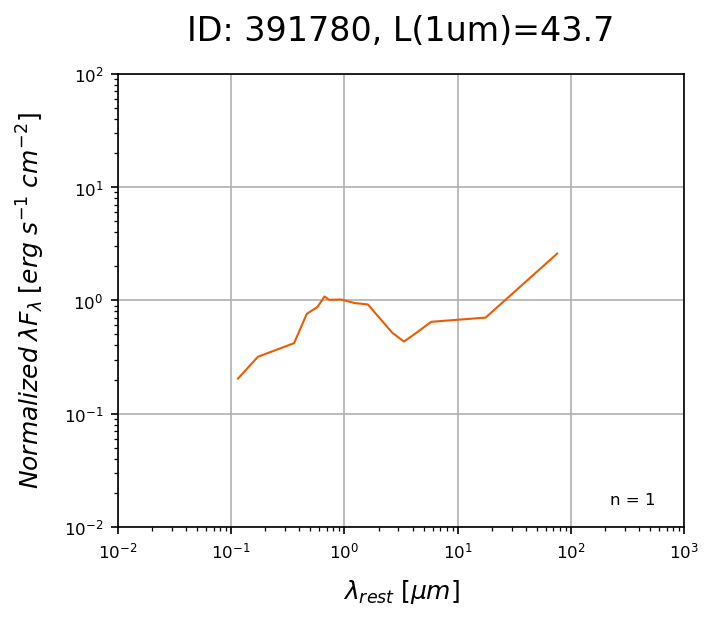

In [25]:
id = agnInfo_zle['RED']['ID'][10]
# id = 0
c, i = GetObjectFromID(id, agnInfo_zle)
print(c,i)

if(i != None) :
    PlotSED_Row(
            x=[agnInfo_zle[c]['Rest Wavelength'][i]            ],
            y=[agnInfo_zle[c]['Energy Density Normalized at 1um'][i]            ],            
            z=[agnInfo_zle[c]['Luminosity at 1um'][i]            ],
            cmapKey=[c            ],      
            # save=adp.path_fig+'\\v2_SED_ID_' + str(id) + '.png',      
            orientWide=False,
            showBar=False,
            ymin=10**-2,
            ymax=10**2,
            title='ID: '+str(id) + ', L(1um)=' + str(round( np.log10(agnInfo_zle[c]['Luminosity at 1um'][i]), 2))
    )
else:
    print("No galaxy with ID", id)

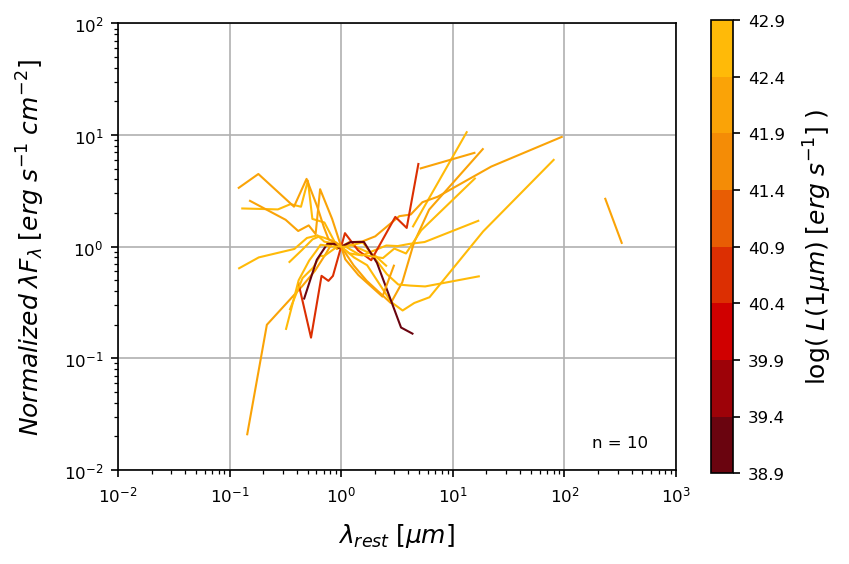

In [26]:
# plot L(1um) outlier SEDs
i_out = np.where( agnInfo_zle['RED']['Luminosity at 1um'] < 10**43.0 )[0]
PlotSED_Row(
        x=[
                agnInfo_zle['RED']['Rest Wavelength'][i_out]
        ],
        y=[     agnInfo_zle['RED']['Energy Density Normalized at 1um'][i_out]
        ],            
        z=[     agnInfo_zle['RED']['Luminosity at 1um'][i_out]
        ],
        cmapKey=['r'],      
        save=adp.path_fig+'\\v2_SED_red_lowL1um_z01.png',      
        orientWide=False,
        cbarLabel='$\log( \; L(1 \mu m) \; [erg \; s^{-1}] \;)$',
        # cbarRange=(43,45),
        n_ticks=9,
        ymin=10**-2,
        ymax=10**2,
        median=False
)
